   employee_id snapshot_date  age        department business_unit  \
0            1     30/4/2021   35  Customer Success    Commercial   
1            1     31/5/2021   35  Customer Success    Commercial   
2            1     30/6/2021   35  Customer Success    Commercial   
3            1     31/7/2021   35  Customer Success    Commercial   
4            1     31/8/2021   35  Customer Success    Commercial   

        job_title     location  base_salary  bonus_eligible  bonus_pct  ...  \
0  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
1  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
2  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
3  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
4  Senior Analyst  Seattle, WA        77073               0        0.0  ...   

   training_count  job_level last_training_date vacation_leave sick_leave  \
0               2          1     

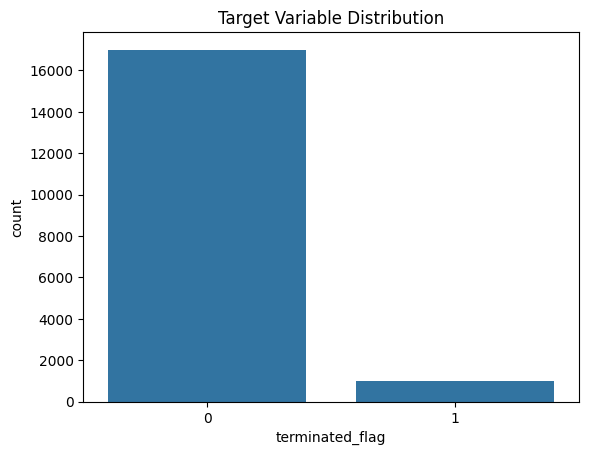

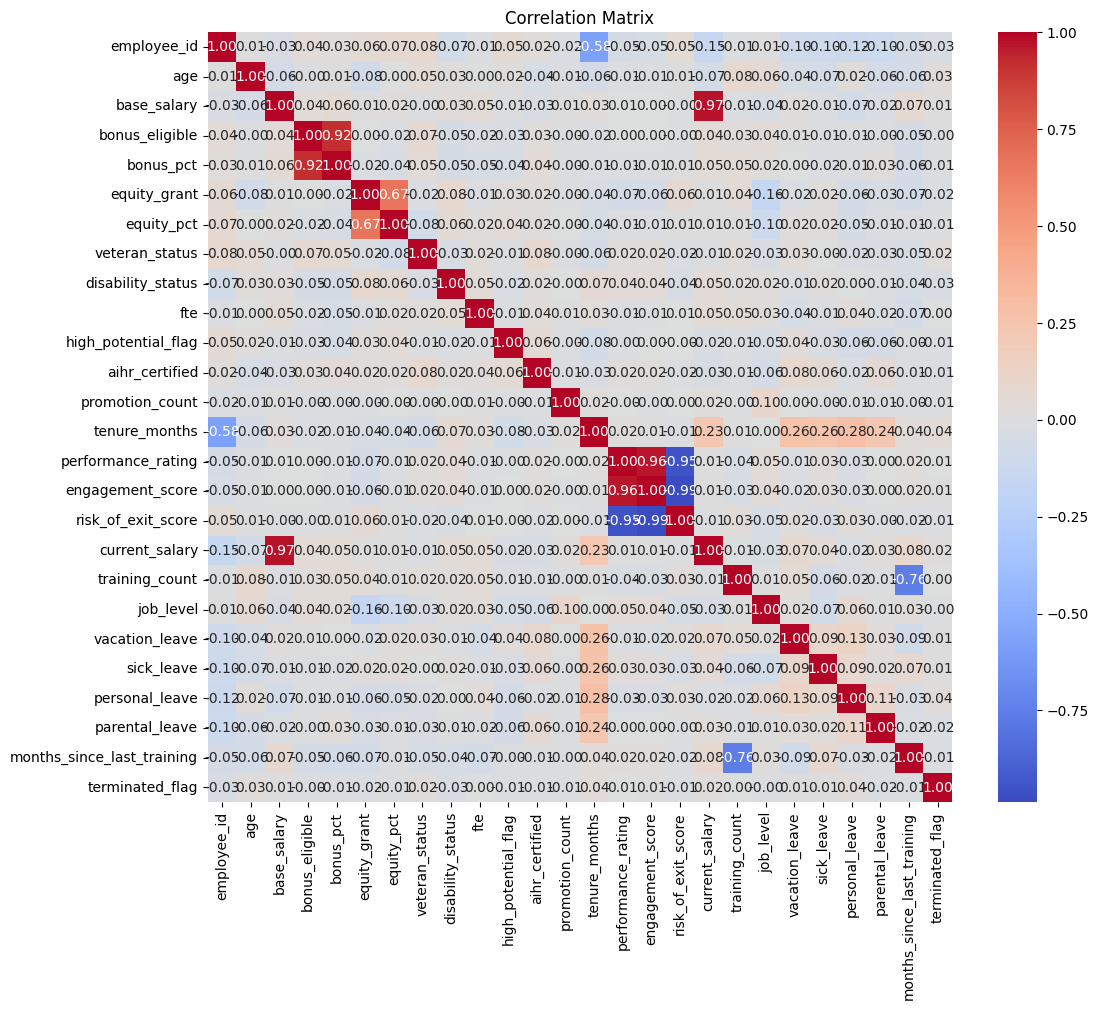

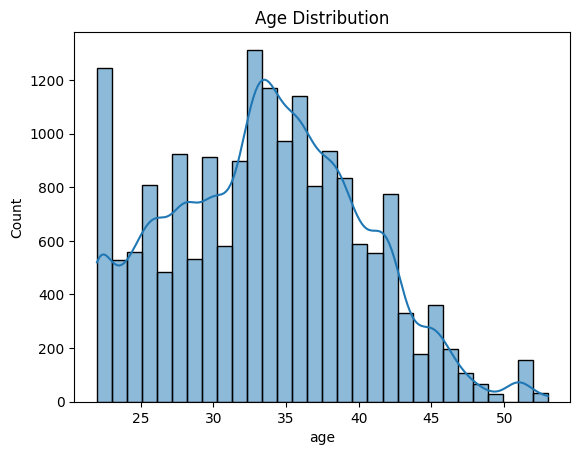

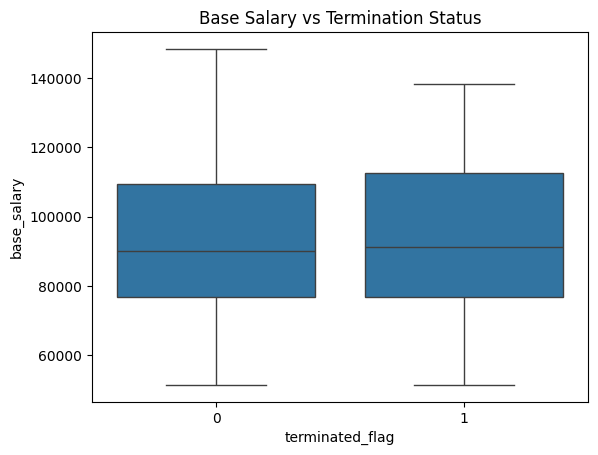

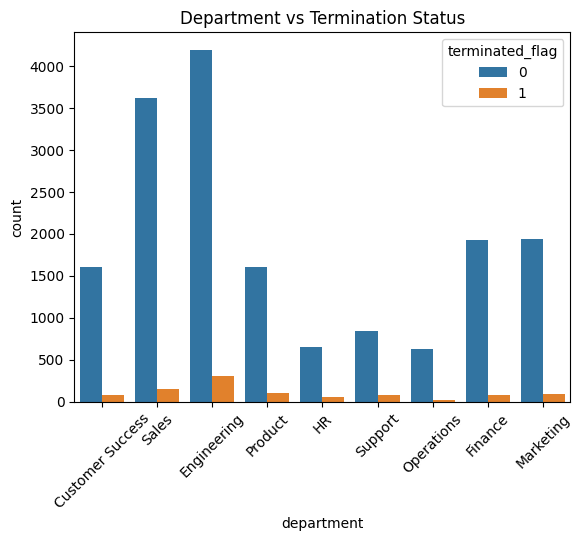

In [33]:
# EDA.ipynb

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('full summary.csv')

# Basic overview
print(df.head())
print(df.info())
print(df.describe())

# Check target variable balance
sns.countplot(x='terminated_flag', data=df)
plt.title('Target Variable Distribution')
plt.show()

# Correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Additional EDA plots (example)
# Distribution of age
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Boxplot of base salary by termination status
sns.boxplot(x='terminated_flag', y='base_salary', data=df)
plt.title('Base Salary vs Termination Status')
plt.show()

# Countplot of department by termination status
sns.countplot(x='department', hue='terminated_flag', data=df)
plt.title('Department vs Termination Status')
plt.xticks(rotation=45)
plt.show()

# (Add any other EDA plots you want here)


In [34]:
# Preprocessing.ipynb

# Imports
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv('full summary.csv')

# Convert dates
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['hire_date'] = pd.to_datetime(df['hire_date'])
df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce')

# Feature engineering
df['months_since_hire'] = (df['snapshot_date'] - df['hire_date']).dt.days // 30

# Drop columns you don't want to use as features or that leak info
drop_cols = ['employee_id', 'snapshot_date', 'hire_date', 'termination_date']
df = df.drop(columns=drop_cols)

# Define target and features
X = df.drop(columns=['terminated_flag'])
y = df['terminated_flag']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- FIX 1: Add the missing train_test_split ---
# Split data into training and testing sets BEFORE any preprocessing
# stratify=y is recommended for classification to maintain target distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # It's often easier to work with dense arrays downstream
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    # Use remainder='passthrough' as a safeguard against accidentally forgetting columns
    remainder='passthrough'
)

# --- FIX 2: Fit the preprocessor ONLY on the training data ---
preprocessor.fit(X_train)


# Transform both the training and testing data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# --- FIX 3: Instantiate SMOTE before using it ---
smote = SMOTE(random_state=42)

# Apply SMOTE ONLY to the training data to prevent data leakage
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)


# --- SAVE ARTIFACTS ---

# Save preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Get feature names from the fitted preprocessor
feature_names = preprocessor.get_feature_names_out()

# Save feature names separately just in case
pd.Series(feature_names).to_csv('feature_names.csv', index=False)

# Save the resampled training data
pd.DataFrame(X_train_resampled, columns=feature_names).to_csv('X_train_resampled.csv', index=False)
y_train_resampled.to_csv('y_train_resampled.csv', index=False)

# Save the transformed testing data
pd.DataFrame(X_test_transformed, columns=feature_names).to_csv('X_test_transformed.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Preprocessing completed successfully!")
print(f"Shape of resampled training features: {X_train_resampled.shape}")
print(f"Shape of transformed testing features: {X_test_transformed.shape}")



C:\Users\amiru\AppData\Local\Temp\ipykernel_3056\3471483211.py:17: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
C:\Users\amiru\AppData\Local\Temp\ipykernel_3056\3471483211.py:18: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['hire_date'] = pd.to_datetime(df['hire_date'])
C:\Users\amiru\AppData\Local\Temp\ipykernel_3056\3471483211.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce')


Preprocessing completed successfully!
Shape of resampled training features: (27214, 213)
Shape of transformed testing features: (3602, 213)


Random Forest ROC AUC mean: 0.9999325517348747
Logistic Regression ROC AUC mean: 0.8343268672413451


c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\amiru\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [22:08:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are no

XGBoost ROC AUC mean: 0.9990612701863606

--- Classification Report - Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3402
           1       0.92      0.88      0.90       200

    accuracy                           0.99      3602
   macro avg       0.96      0.94      0.95      3602
weighted avg       0.99      0.99      0.99      3602



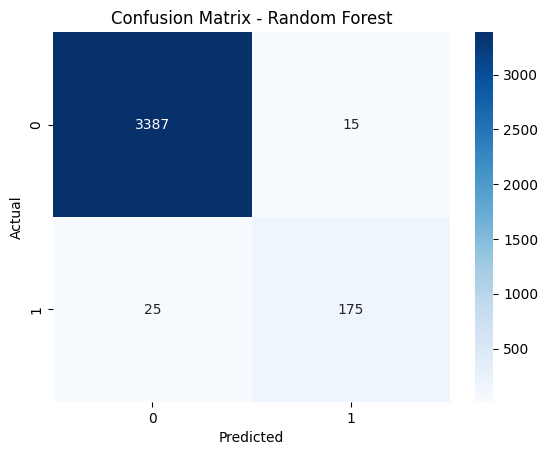

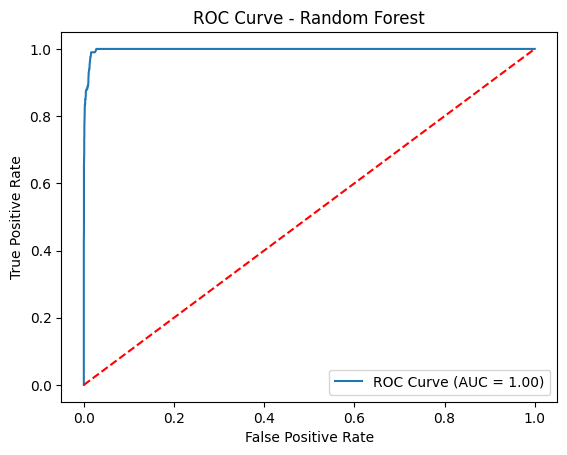


--- Classification Report - Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      3402
           1       0.13      0.72      0.22       200

    accuracy                           0.71      3602
   macro avg       0.55      0.72      0.52      3602
weighted avg       0.93      0.71      0.79      3602



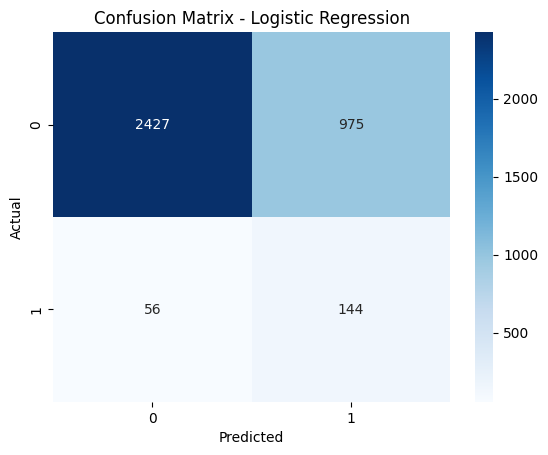

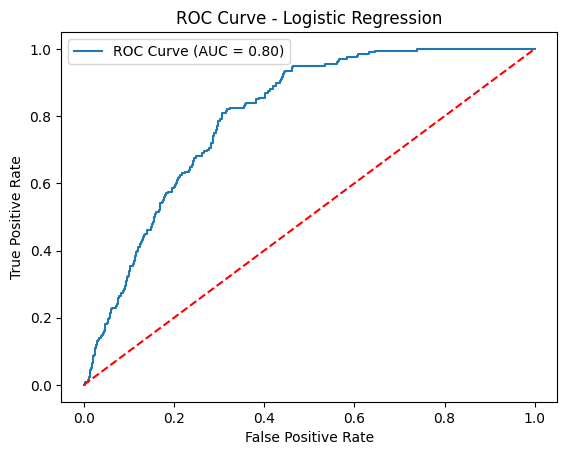


--- Classification Report - XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3402
           1       0.73      0.90      0.81       200

    accuracy                           0.98      3602
   macro avg       0.86      0.94      0.90      3602
weighted avg       0.98      0.98      0.98      3602



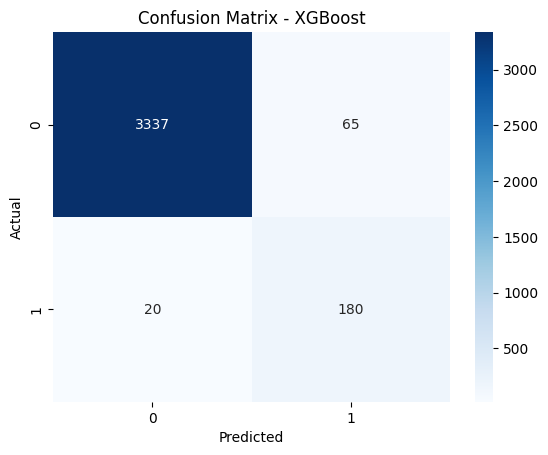

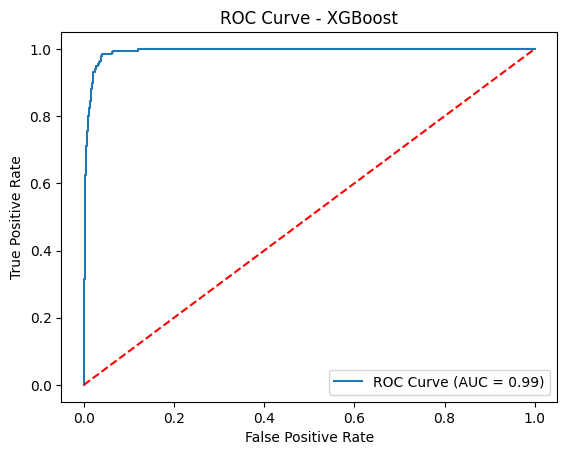

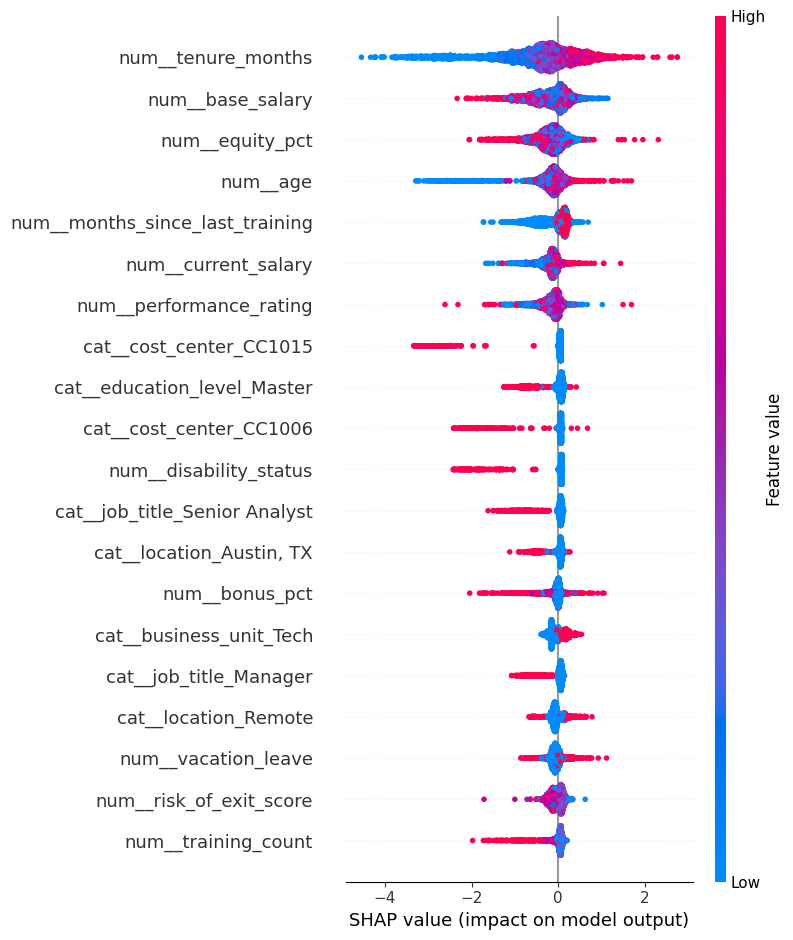


Modeling and evaluation complete.
Test set results with predictions saved to 'test_set_predictions_and_results.csv'


In [36]:
# Modeling.ipynb

# Imports
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import shap

# ----- FIX 1: Load the data -----
# This data is ALREADY PROCESSED, so we will not use the preprocessor on it again.
X_train = pd.read_csv('X_train_resampled.csv')
y_train = pd.read_csv('y_train_resampled.csv').squeeze() # .squeeze() is good practice
X_test = pd.read_csv('X_test_transformed.csv')
y_test = pd.read_csv('y_test.csv').squeeze()

# The feature names are now the columns of the loaded DataFrames
feature_names = X_train.columns.tolist()


# ----- FIX 2: Remove the 'preprocessor' step from all pipelines -----

# ----- Random Forest Model -----
# The pipeline now only contains the classifier
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

# Now fit directly on the preprocessed data
rf_pipeline.fit(X_train, y_train)
# Note: Cross-validation here is validating the model on different folds of the SMOTE'd data.
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest ROC AUC mean:", rf_scores.mean())


# ----- Logistic Regression Model -----
logreg_pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_pipeline.fit(X_train, y_train)
logreg_scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression ROC AUC mean:", logreg_scores.mean())


# ----- XGBoost Model -----
xgb_pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("XGBoost ROC AUC mean:", xgb_scores.mean())


# ----- Extract and save model insights -----
# The feature names are now simply the columns of the X_train DataFrame.
logreg_model = logreg_pipeline.named_steps['classifier']
coefficients = logreg_model.coef_[0]
logreg_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)
logreg_coef_df.to_csv('logreg_coefficients.csv', index=False)

xgb_model = xgb_pipeline.named_steps['classifier']
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
xgb_feature_importance.to_csv('xgb_feature_importance.csv', index=False)


# ----- Evaluation on test set -----
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n--- Classification Report - {model_name} ---")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    return y_pred, y_proba

# Evaluate all models
rf_pred, rf_proba = evaluate_model(rf_pipeline, X_test, y_test, 'Random Forest')
logreg_pred, logreg_proba = evaluate_model(logreg_pipeline, X_test, y_test, 'Logistic Regression')
xgb_pred, xgb_proba = evaluate_model(xgb_pipeline, X_test, y_test, 'XGBoost')


# ----- SHAP explanations for XGBoost -----
# The input X_test is already the transformed data the model expects
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test) # Use X_test directly

# Convert X_test to a DataFrame for better plotting labels
X_test_df_for_shap = pd.DataFrame(X_test, columns=feature_names)
shap.summary_plot(shap_values, X_test_df_for_shap)


# ----- FIX 3: Export test set results correctly -----
# Create a new DataFrame with the test data and its corresponding predictions.
# Merging with the original full CSV is not feasible without the original row indices.
results_df = X_test.copy()
results_df['actual_terminated_flag'] = y_test.values
results_df['rf_prediction'] = rf_pred
results_df['rf_probability'] = rf_proba
results_df['logreg_prediction'] = logreg_pred
results_df['logreg_probability'] = logreg_proba
results_df['xgb_prediction'] = xgb_pred
results_df['xgb_probability'] = xgb_proba

# Save the detailed results of your test set
results_df.to_csv('test_set_predictions_and_results.csv', index=False)

print("\nModeling and evaluation complete.")
print("Test set results with predictions saved to 'test_set_predictions_and_results.csv'")